# mlcrashcourse - Deep Learning Practical



## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from random import randint
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from tensorflow.keras.datasets import fashion_mnist

import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (InputLayer, Dense, BatchNormalization, Dense, Dropout, 
                                     Conv2D, Flatten, MaxPool2D)
from tensorflow.keras.metrics import categorical_accuracy, categorical_crossentropy
from tensorflow.keras.optimizers import Adam

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Defining the problem

Link to dataset: https://www.kaggle.com/zalando-research/fashionmnist

In this practical we will be using the **Fashion MNIST** dataset. The task is to classify the image into the different fashion classes/labels. 

> Basically, given an image of a boot, the model should be able to tell me that that is a boot.

| No. Label | Text Label |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |


This is a supervised problem because there is a expected output we want to obtain from the model.




## Load the Data

In [2]:
label_map = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

# load the data using keras datasets
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
print(f"{len(train_images)} training examples, {len(test_images)} test examples")

60000 training examples, 10000 test examples


Take a look at a random image and its label

This is a: T-shirt/top


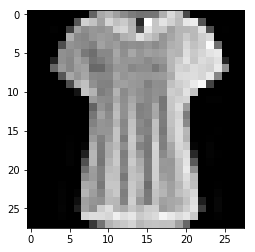

In [3]:
idx = randint(0, len(train_images))
image = train_images[idx]
label_i = train_labels[idx]
print("This is a:", label_map[label_i])
plt.imshow(image, cmap='gray')

## Prepare the data
Neural Networks are fussy with the data that they take in, so we need to do some preprocessing:
1. Apply Feature Scaling to the images
2. One hot encode the labels

### Feature Scaling

In [4]:
# Perform feature scaling with standard scaler 
# np.reshape() is needed to ensure that the np arrays have the correct shape
n_images = len(train_images)
scaler = StandardScaler()
flat_train_images = np.reshape(train_images, (n_images, -1))

# we need to tell the scaler about what data it will be dealing with
scaler.fit(flat_train_images)

# Define a function to scale features
def scale_features(images):
    flat_images = np.reshape(images, (len(images), -1))
    flat_features = scaler.transform(flat_images)
    features = np.reshape(flat_features, (len(images), 28, 28, 1))
    return features 

# Scale both train and test images
train_features = scale_features(train_images)
test_features = scale_features(test_images)

/home/zzy/.conda/envs/ml/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/zzy/.conda/envs/ml/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/zzy/.conda/envs/ml/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Before:

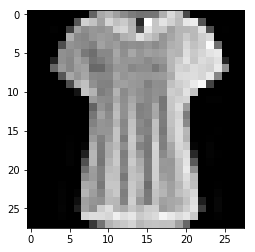

In [5]:
plt.imshow(train_images[idx], cmap='gray')

After scaling:

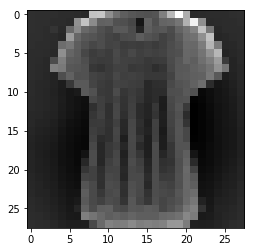

In [6]:
plt.imshow(train_features[idx].reshape(28, 28), cmap='gray')

### One Hot Encoding

In [7]:
# we need to tell the encoder about what data it will be dealing with
encoder = OneHotEncoder()
encoder.fit(np.reshape(train_labels, (len(train_labels), 1)))

# convert labels into one hot encoding
def encode_labels(labels):
    labels = np.reshape(labels, (len(labels), 1))
    features = encoder.transform(labels)
    return features
                        
train_one_hot_labels = encode_labels(train_labels)
test_one_hot_labels = encode_labels(test_labels)

/home/zzy/.conda/envs/ml/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Before:

In [8]:
train_labels[0]

9

After encoding:

In [16]:
train_one_hot_labels[0].toarray()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

### Building the Model
Now we build the Neural Network model that we will train to classify fashion images.
Instead of directly building the model, we create a class that exposes its hyperparameters.
This will make hyperparameters tuning later easier.

A function that adds a convolution block to your model is provided:

In [17]:
# Add a convolution block to the given sequential model if enabled
# layers specify how many convolution layers to use
# the scale parameter allows us to scale up the convolution layers
def add_conv_block(model, layers, scale, dropout=0.2):
        for n_base_filters in range(2, layers * 2 + 1, 2):
            model.add(Conv2D(int(n_base_filters * scale), (3, 3),
                             padding="same",activation="relu"))
            model.add(Conv2D(int(n_base_filters * scale), (3, 3),
                             padding="same",activation="relu"))
            model.add(Conv2D(int(n_base_filters * scale), (3, 3), 
                             strides=(2,2), padding="same",activation="relu"))        
            model.add(BatchNormalization())
            model.add(Dropout(dropout))
            
        model.add(Flatten())
        

In [18]:
# Represents a neural network model
class NNModel:
    # Create a model with the given hyperparametersz
    def __init__(self, 
                 n_layers,
                 learning_rate,
                 n_units=64,
                 conv_blocks=0,
                 conv_scale=0,
                 display_summary=False):
        
        self.input_shape = (28, 28, 1)
        self.n_units = n_units
        self.n_layers = n_layers
        self.learning_rate = learning_rate
        self.conv_scale = conv_scale
        self.conv_blocks = conv_blocks
        
        self.backend_model = self.build()
        if display_summary: self.backend_model.summary()
        
    # Fit the model to the given data
    # x - features, y - one hot encoded labels
    def fit(self, train_x, train_y, valid_data, n_epochs, batch_size=64):
        self.backend_model.fit(train_x, train_y,
                               validation_data=valid_data,
                               epochs=n_epochs,
                               batch_size=batch_size)

    # Generate predictions using the given features
    def predict(self, input_x):
        predict_probs = self.backend_model.predict(input_x, 
                                                 batch_size=64)
        predictions = np.argmax(predict_probs, axis=-1)
        return predictions
    

    # Build the model
    def build(self):
        K.clear_session()
        
        # Build model architecture
        model = Sequential()
        model.add(InputLayer(input_shape=self.input_shape))
        # Convolution layers
        add_conv_block(model, 
                       layers=self.conv_blocks,
                       scale=self.conv_scale)
        # Dense layers (The brain part)
        for i in range(self.n_layers): 
            model.add(Dense(self.n_units, activation="relu"))
            
        # Output layer - classfication 10 classes
        model.add(Dense(10, activation="sigmoid"))

        # Build model
        model.compile(optimizer=Adam(lr=self.learning_rate),
                      loss=categorical_crossentropy,
                      metrics=[categorical_accuracy])
        
        return model
    
    

# Training the model
Lets build a model with our model class and train it.
As usual, there are hyperparameters in or model that we have to tune.
We train for 3 epochs, which means that we tell the model to learn from the training data over 3 passes.

> In real world, we train for way more epochs (30-200)


In [19]:
model = NNModel(n_layers=2,
                n_units=64, 
                conv_blocks=0,
                conv_scale=12,
                learning_rate=3e-3, 
                display_summary=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


Train model on the training data

In [21]:
hist = model.fit(train_features, train_one_hot_labels, 
                 valid_data=(test_features, test_one_hot_labels),
                 n_epochs=3)

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 8s 135us/sample - loss: 0.4061 - categorical_accuracy: 0.8565 - val_loss: 0.4106 - val_categorical_accuracy: 0.8522
Epoch 2/3
60000/60000 [==============================] - 8s 131us/sample - loss: 0.3385 - categorical_accuracy: 0.8758 - val_loss: 0.3837 - val_categorical_accuracy: 0.8619
Epoch 3/3
60000/60000 [==============================] - 8s 138us/sample - loss: 0.3095 - categorical_accuracy: 0.8862 - val_loss: 0.4047 - val_categorical_accuracy: 0.8559


## Evaluting the model
One we have have trained the model, we need to evalute how when its doing. We will use the `categorical_accuracy` metric as a yard stick of evaluating how the model is doing 


In [22]:
predictions = model.predict(test_features)
accuracy = accuracy_score(predictions, test_labels)
print(f"The model is {accuracy * 100.0}% accurate")

The model is 85.59% accurate


## Iterating and Experimenting
Now we make changes to the hyperparameters of models and evalute.
And then do it again (iterating), trying to get models with higher accuracy.

For today, we will only have time for one hyperparamer
How about we add some convolution layers?

In [26]:
model = NNModel(n_layers=2,
                n_units=64, 
                conv_blocks=1,
                conv_scale=12,
                learning_rate=3e-3,
                display_summary=True)
                
hist = model.fit(train_features, train_one_hot_labels, 
                 valid_data=(test_features, test_one_hot_labels),
                 batch_size=64,
                 n_epochs=3)

predictions = model.predict(test_features)
accuracy = accuracy_score(predictions, test_labels)
print(f"The model is {accuracy * 100.0}% accurate")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 24)        240       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 24)        5208      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 24)        5208      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 14, 14, 24)        96        
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 24)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4704)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                301120    
__________

Since we are on a time limit today thats all that we will will try. But i suggest that you try other values at home.

>Neural Networks are able scale to large amount of data, but require large amount of computing resources use effectively